<a href="https://colab.research.google.com/github/zhuzihan728/COMP0138-Metal-Binding-Site-Prediction/blob/main/colab_scripts/split_set_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [ ]:
!pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
import json
import numpy as np
import random

# Extract datasets

In [ ]:
%env MY_PATH=/content/drive/MyDrive/FYP

env: MY_PATH=/content/drive/MyDrive/FYP


In [ ]:
import os

my_path = os.environ['MY_PATH']   
my_path

'/content/drive/MyDrive/FYP'

In [ ]:
!tar -xvf /content/drive/MyDrive/FYP/uniprot_datasets

ChEBI-IDs_for_metal_binding.tsv
NEG_clustered_rep_seq.fasta
NEG_TRAIN.fasta
POS_TRAIN.fasta
POS_TRAIN_FULL.fasta
POS_TRAIN_FULL.tsv
POS_TRAIN.tsv
filtered_combined.fasta
trimed_combined.fasta


In [ ]:
!cat POS_TRAIN.fasta NEG_TRAIN.fasta > combined.fasta

In [ ]:
total_len = len(list(SeqIO.parse("combined.fasta", "fasta")))
print("Full data set size: ", total_len)

Full data set size:  195450


In [ ]:
# !cp /content/drive/MyDrive/FYP/full_test40.fasta full_test40.fasta

In [ ]:
# !cp /content/drive/MyDrive/FYP/full_train40.fasta full_train40.fasta

# Helper functions

In [ ]:
def check_metal_per(seqs, metal, anno, metal_count_df):
  cnt = 0
  temp = anno.loc[anno['Accession'].isin(seqs)]
  temp1 = temp['ChEBI-ID'].value_counts().to_frame().reset_index()
  row = temp1[temp1['index'] == metal]['ChEBI-ID']
  cnt = 0 if len(row) == 0 else int(row)
  per = cnt / int(metal_count_df[metal_count_df['ChEBI-ID'] == metal]['count'])
  return per

In [ ]:
def check_metal_num(seqs, metal, anno):
  cnt = 0
  temp = anno.loc[anno['Accession'].isin(seqs)]
  temp1 = temp['ChEBI-ID'].value_counts().to_frame().reset_index()
  row = temp1[temp1['index'] == metal]['ChEBI-ID']
  cnt = 0 if len(row) == 0 else int(row)
  return cnt

In [ ]:
def check_metal_specific_residue_proportion(acc_ls, source = 'POS_TRAIN_FULL.tsv'):
  anno = pd.read_csv(source, sep='\t')
  metal_count_df = anno['ChEBI-ID'].value_counts().to_frame().reset_index()
  metal_count_df.columns = ['ChEBI-ID', 'count']
  metal_id_name_df = pd.read_csv('ChEBI-IDs_for_metal_binding.tsv', sep='\t')
  for metal in metal_count_df['ChEBI-ID'].unique():
    metal_name = metal_id_name_df[metal_id_name_df['ChEBI-ID']==metal]['Name'].iloc[0]
    num = check_metal_num(acc_ls, metal, anno) 
    total_num = int(metal_count_df[metal_count_df['ChEBI-ID'] == metal]['count'])
    print(f'{metal:12}| {metal_name:29} | num: {int(num):6} | %: {num/total_num}')

In [ ]:
def write_seq_ls2fasta(file_out, ls, source):
  with open(file_out, 'w') as f_out:
    for seq_record in SeqIO.parse(source, "fasta"):
      seq_acc = seq_record.id.split('|')[1]
      if seq_acc in ls:
        r = SeqIO.write(seq_record, f_out, 'fasta')

        if r!=1: 
          print('Error while writing sequence: ' + seq_acc)
        else:
          print(f'writing {seq_acc} to train fasta file.')

In [ ]:
def fasta2acc_seq_ls(path):
  acc = []
  seq = []

  for seq_record in SeqIO.parse(path, "fasta"):
    acc.append(seq_record.id.split('|')[1])
    seq.append(str(seq_record.seq))
  return acc, seq

In [ ]:
def check_pos_neg_proportion(ls):
  total_num = len(ls)
  
  acc, _ = fasta2acc_seq_ls("POS_TRAIN_FULL.fasta")
  inter = set(acc).intersection(ls)
  pos_num = len(inter)
  neg_num = total_num - pos_num
  pos_portion = pos_num/total_num
  neg_portion = neg_num/total_num
  print(f'total seq in the set: {total_num}')
  print(f'proportion over full dataset: {total_num/total_len}')
  print(f'pos: {pos_num} %: {pos_portion}')
  print(f'neg: {neg_num} %: {neg_portion}')
  return total_num, pos_num, neg_num, pos_portion, neg_portion

In [ ]:
def identity_above_threshold(m8file, thres):
  data = pd.read_csv(m8file, sep="\t", index_col=False, header=None)
  data.columns = ["query", "target","sequence identity","alignment length","mismatch","gap opening", "query domain start position", "end position","target domain start position", "end position", "evalue", "bit score"]
  
  seq_above_thres = data[data["sequence identity"] > thres]["query"].unique()
  seq_below_thres = data[~data["query"].isin(seq_above_thres)]["query"].unique()
  # print(data[data["sequence identity"] > thres]["sequence identity"].unique())
  all_seq = data["query"].unique()
  print(len(all_seq))
  proportion = len(seq_above_thres) / len(all_seq)
  print(len(all_seq) == len(seq_above_thres) + len(seq_below_thres))
  return seq_above_thres, seq_below_thres, proportion

In [ ]:
def target_identity_above_threshold(m8file, thres):
  data = pd.read_csv(m8file, sep="\t", index_col=False, header=None)
  data.columns = ["query", "target","sequence identity","alignment length","mismatch","gap opening", "query domain start position", "end position","target domain start position", "end position", "evalue", "bit score"]
  
  seq_above_thres = data[data["sequence identity"] > thres]["target"].unique()
  seq_below_thres = data[~data["target"].isin(seq_above_thres)]["target"].unique()
  # print(data[data["sequence identity"] > thres]["sequence identity"].unique())
  all_seq = data["target"].unique()
  print(len(all_seq))
  proportion = len(seq_above_thres) / len(all_seq)
  print(len(all_seq) == len(seq_above_thres) + len(seq_below_thres))
  return seq_above_thres, seq_below_thres, proportion

In [ ]:
def read_fasta(fasta_path, split_char="|", id_field=1):
    '''
        Reads in fasta file containing multiple sequences.
        Split_char and id_field allow to control identifier extraction from header.
        E.g.: set split_char="|" and id_field=1 for SwissProt/UniProt Headers.
        Returns dictionary holding multiple sequences or only single 
        sequence, depending on input file.
    '''
    
    seqs = dict()
    with open( fasta_path, 'r' ) as fasta_f:
        for line in fasta_f:
            # get uniprot ID from header and create new entry
            if line.startswith('>'):
                uniprot_id = line.replace('>', '').strip().split(split_char)[id_field]
                # replace tokens that are mis-interpreted when loading h5
                uniprot_id = uniprot_id.replace("/","_").replace(".","_")
                seqs[ uniprot_id ] = ''
            else:
                # repl. all whie-space chars and join seqs spanning multiple lines, drop gaps and cast to upper-case
                seq= ''.join( line.split() ).upper().replace("-","")
                # repl. all non-standard AAs and map them to unknown/X
                seq = seq.replace('U','X').replace('Z','X').replace('O','X')
                seqs[ uniprot_id ] += seq 
    example_id=next(iter(seqs))
    print("Read {} sequences.".format(len(seqs)))
    print("Example:\n{}\n{}".format(example_id,seqs[example_id]))

    return seqs

In [ ]:
def dataset_metal_binding_summary(acc_ls, source = 'POS_TRAIN_FULL.tsv' , coalesce = True):
  total_num = len(acc_ls)
  print(f'total seq in the set: {total_num}, {total_num/total_len*100:.{3}}% of full dataset')
  
  all_pos_acc_ls, _ = fasta2acc_seq_ls("POS_TRAIN_FULL.fasta")
  if coalesce:
    metals =  {'CHEBI:29105':0,'CHEBI:18420':1,'CHEBI:49883':2,'CHEBI:29108':3,'CHEBI:29035':4,'CHEBI:60240':5,'CHEBI:24875':6,'CHEBI:190135':7,'CHEBI:23378':8,'CHEBI:29103':9,'CHEBI:49786':10,'CHEBI:29101':11,'CHEBI:29034':12,'CHEBI:30408':13,'CHEBI:29036':14,'CHEBI:29033':15, 'CHEBI:48828':16, 'CHEBI:25213':17, 'CHEBI:21137':13,'CHEBI:49552':8,'CHEBI:48775':5,'CHEBI:21143':13,'CHEBI:47739':13,'CHEBI:16793':5,'CHEBI:177874':13,'CHEBI:60400':13,'CHEBI:49415':17, 'CHEBI:49713':17}
  else:
    metals = {'CHEBI:29105':0,'CHEBI:18420':1,'CHEBI:49883':2,'CHEBI:29108':3,'CHEBI:29035':4,'CHEBI:60240':5,'CHEBI:24875':6,'CHEBI:190135':7,'CHEBI:23378':8,'CHEBI:29103':9,'CHEBI:49786':10,'CHEBI:29101':11,'CHEBI:29034':12,'CHEBI:30408':13,'CHEBI:29036':14,'CHEBI:29033':15,'CHEBI:21137':16,'CHEBI:49552':17,'CHEBI:48775':18,'CHEBI:48828':19,'CHEBI:21143':20,'CHEBI:25213':21,'CHEBI:47739':22,'CHEBI:16793':23,'CHEBI:177874':24,'CHEBI:60400':25,'CHEBI:49415':26,'CHEBI:60504':27,'CHEBI:49713':28}
  anno = pd.read_csv(source, sep='\t')
  metal_count_df = anno['ChEBI-ID'].value_counts().to_frame().reset_index()
  metal_count_df.columns = ['ChEBI-ID', 'count']
  metal_id_name_df = pd.read_csv('ChEBI-IDs_for_metal_binding.tsv', sep='\t')
  prot_counter = [0]*29 
  res_counter = [0]*29
  pos_acc = set(all_pos_acc_ls).intersection(acc_ls)
  if not total_num == len(pos_acc):
    print(f"#metal-binding protein: {len(pos_acc)} \n#non-binding protein: {total_num-len(pos_acc)} \npos/neg: {len(pos_acc)/(total_num-len(pos_acc))}")
  if coalesce:
      for i, metal in enumerate(metals):
        temp = anno[anno['ChEBI-ID'] == metal]
        prot_counter[metals[metal]] += len(temp[temp['Accession'].isin(pos_acc)]['Accession'].unique())
        res_counter[metals[metal]] += check_metal_num(acc_ls, metal, anno)
      i = 0
      for metal in list(metals.keys())[:18]:
        metal_name = metal_id_name_df[metal_id_name_df['ChEBI-ID']==metal]['Name'].iloc[0]
        print(f"{metal:13}|{metal_name:30}|#p: {prot_counter[i]:10}|#residue: {res_counter[i]:6}")
        i+=1
      return prot_counter, res_counter
        

  for i, metal in enumerate(metals):
    metal_name = metal_id_name_df[metal_id_name_df['ChEBI-ID']==metal]['Name'].iloc[0]
    temp = anno[anno['ChEBI-ID'] == metal]
    prot_counter[i] += len(temp[temp['Accession'].isin(pos_acc)]['Accession'].unique())
    res_counter[i] += check_metal_num(acc_ls, metal, anno)
    total_res_num = np.sum(metal_count_df['count'])
    print(f"{metal:13}|{metal_name:30}|#p: {prot_counter[i]:10}|#residue: {res_counter[i]:6}|% over all binding residues: {res_counter[i]/total_res_num:{5}.{3}}")
  return prot_counter, res_counter, 

In [ ]:
def txt2accls(file):
  ls = []
  with open(file, 'r') as f:
    for i in f.readlines():
      ls.append(i[:-1])
  return ls

In [ ]:
combined_fasta = read_fasta("/content/combined.fasta")
def seq_by_acc(acc):
  seq = []
  for i in acc:
    seq.append(combined_fasta[i])
  return seq

Read 195450 sequences.
Example:
A0A023GPI8
ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGKVGTAHIIYNSVGKRLSAVVSYPNGDSATVSYDVDLDNVLPEWVRVGLSATTGLYKETNTILSWSFTSKLKSNSTHETNALHFMFNQFSKDQKDLILQGDATTGRDGNLELTRVSSNGSPQGSSVGRALFYAPVHIWESSAVVASFDATFTFLIKSSDSHPADGIAFFISNIDSSIPSGSTGRLLGLFPDAN


# Train/test set analysis

In [ ]:
train_acc = txt2accls("/content/trainval_filtered40.txt")
train_seq = seq_by_acc(train_acc)
test_acc = txt2accls("/content/test_filtered40.txt")
test_seq = seq_by_acc(test_acc)
total_acc, total_seq = fasta2acc_seq_ls("/content/combined.fasta")

In [ ]:
dataset_metal_binding_summary(total_acc, source = 'POS_TRAIN.tsv', coalesce=False)
pass

total seq in the set: 195450, 1e+02% of full dataset
#metal-binding protein: 2317 
#non-binding protein: 193133 
pos/neg: 0.0119969140436901
CHEBI:29105  |Zn(2+)                        |#p:        785|#residue:   5788|% over all binding residues: 0.321
CHEBI:18420  |Mg(2+)                        |#p:        530|#residue:   2140|% over all binding residues: 0.119
CHEBI:49883  |[4Fe-4S] cluster              |#p:        121|#residue:    885|% over all binding residues: 0.049
CHEBI:29108  |Ca(2+)                        |#p:        413|#residue:   4768|% over all binding residues: 0.264
CHEBI:29035  |Mn(2+)                        |#p:        195|#residue:   1136|% over all binding residues: 0.063
CHEBI:60240  |a divalent metal cation       |#p:         81|#residue:    738|% over all binding residues: 0.0409
CHEBI:24875  |Fe cation                     |#p:        170|#residue:    919|% over all binding residues: 0.0509
CHEBI:190135 |[2Fe-2S] cluster              |#p:         57|#residue:    

In [ ]:
print(f'train set size: {len(train_acc)}')
print(f'test set size: {len(test_acc)}')
print(len(train_acc) + len(test_acc) == len(total_acc))

train set size: 36457
test set size: 3911
False


## Train Set Summary

In [ ]:
pro_cnt, res_cnt = dataset_metal_binding_summary(train_acc, source = 'POS_TRAIN.tsv', coalesce=True)


total seq in the set: 36457, 18.7% of full dataset
#metal-binding protein: 2093 
#non-binding protein: 34364 
pos/neg: 0.06090676289139797
CHEBI:29105  |Zn(2+)                        |#p:        694|#residue:   5215
CHEBI:18420  |Mg(2+)                        |#p:        476|#residue:   1932
CHEBI:49883  |[4Fe-4S] cluster              |#p:        110|#residue:    798
CHEBI:29108  |Ca(2+)                        |#p:        391|#residue:   4297
CHEBI:29035  |Mn(2+)                        |#p:        172|#residue:   1028
CHEBI:60240  |a divalent metal cation       |#p:         77|#residue:    713
CHEBI:24875  |Fe cation                     |#p:        158|#residue:    833
CHEBI:190135 |[2Fe-2S] cluster              |#p:         53|#residue:    310
CHEBI:23378  |Cu cation                     |#p:         77|#residue:    535
CHEBI:29103  |K(+)                          |#p:         20|#residue:    145
CHEBI:49786  |Ni(2+)                        |#p:         12|#residue:     73
CHEBI:29101  |

<Figure size 2000x1500 with 0 Axes>

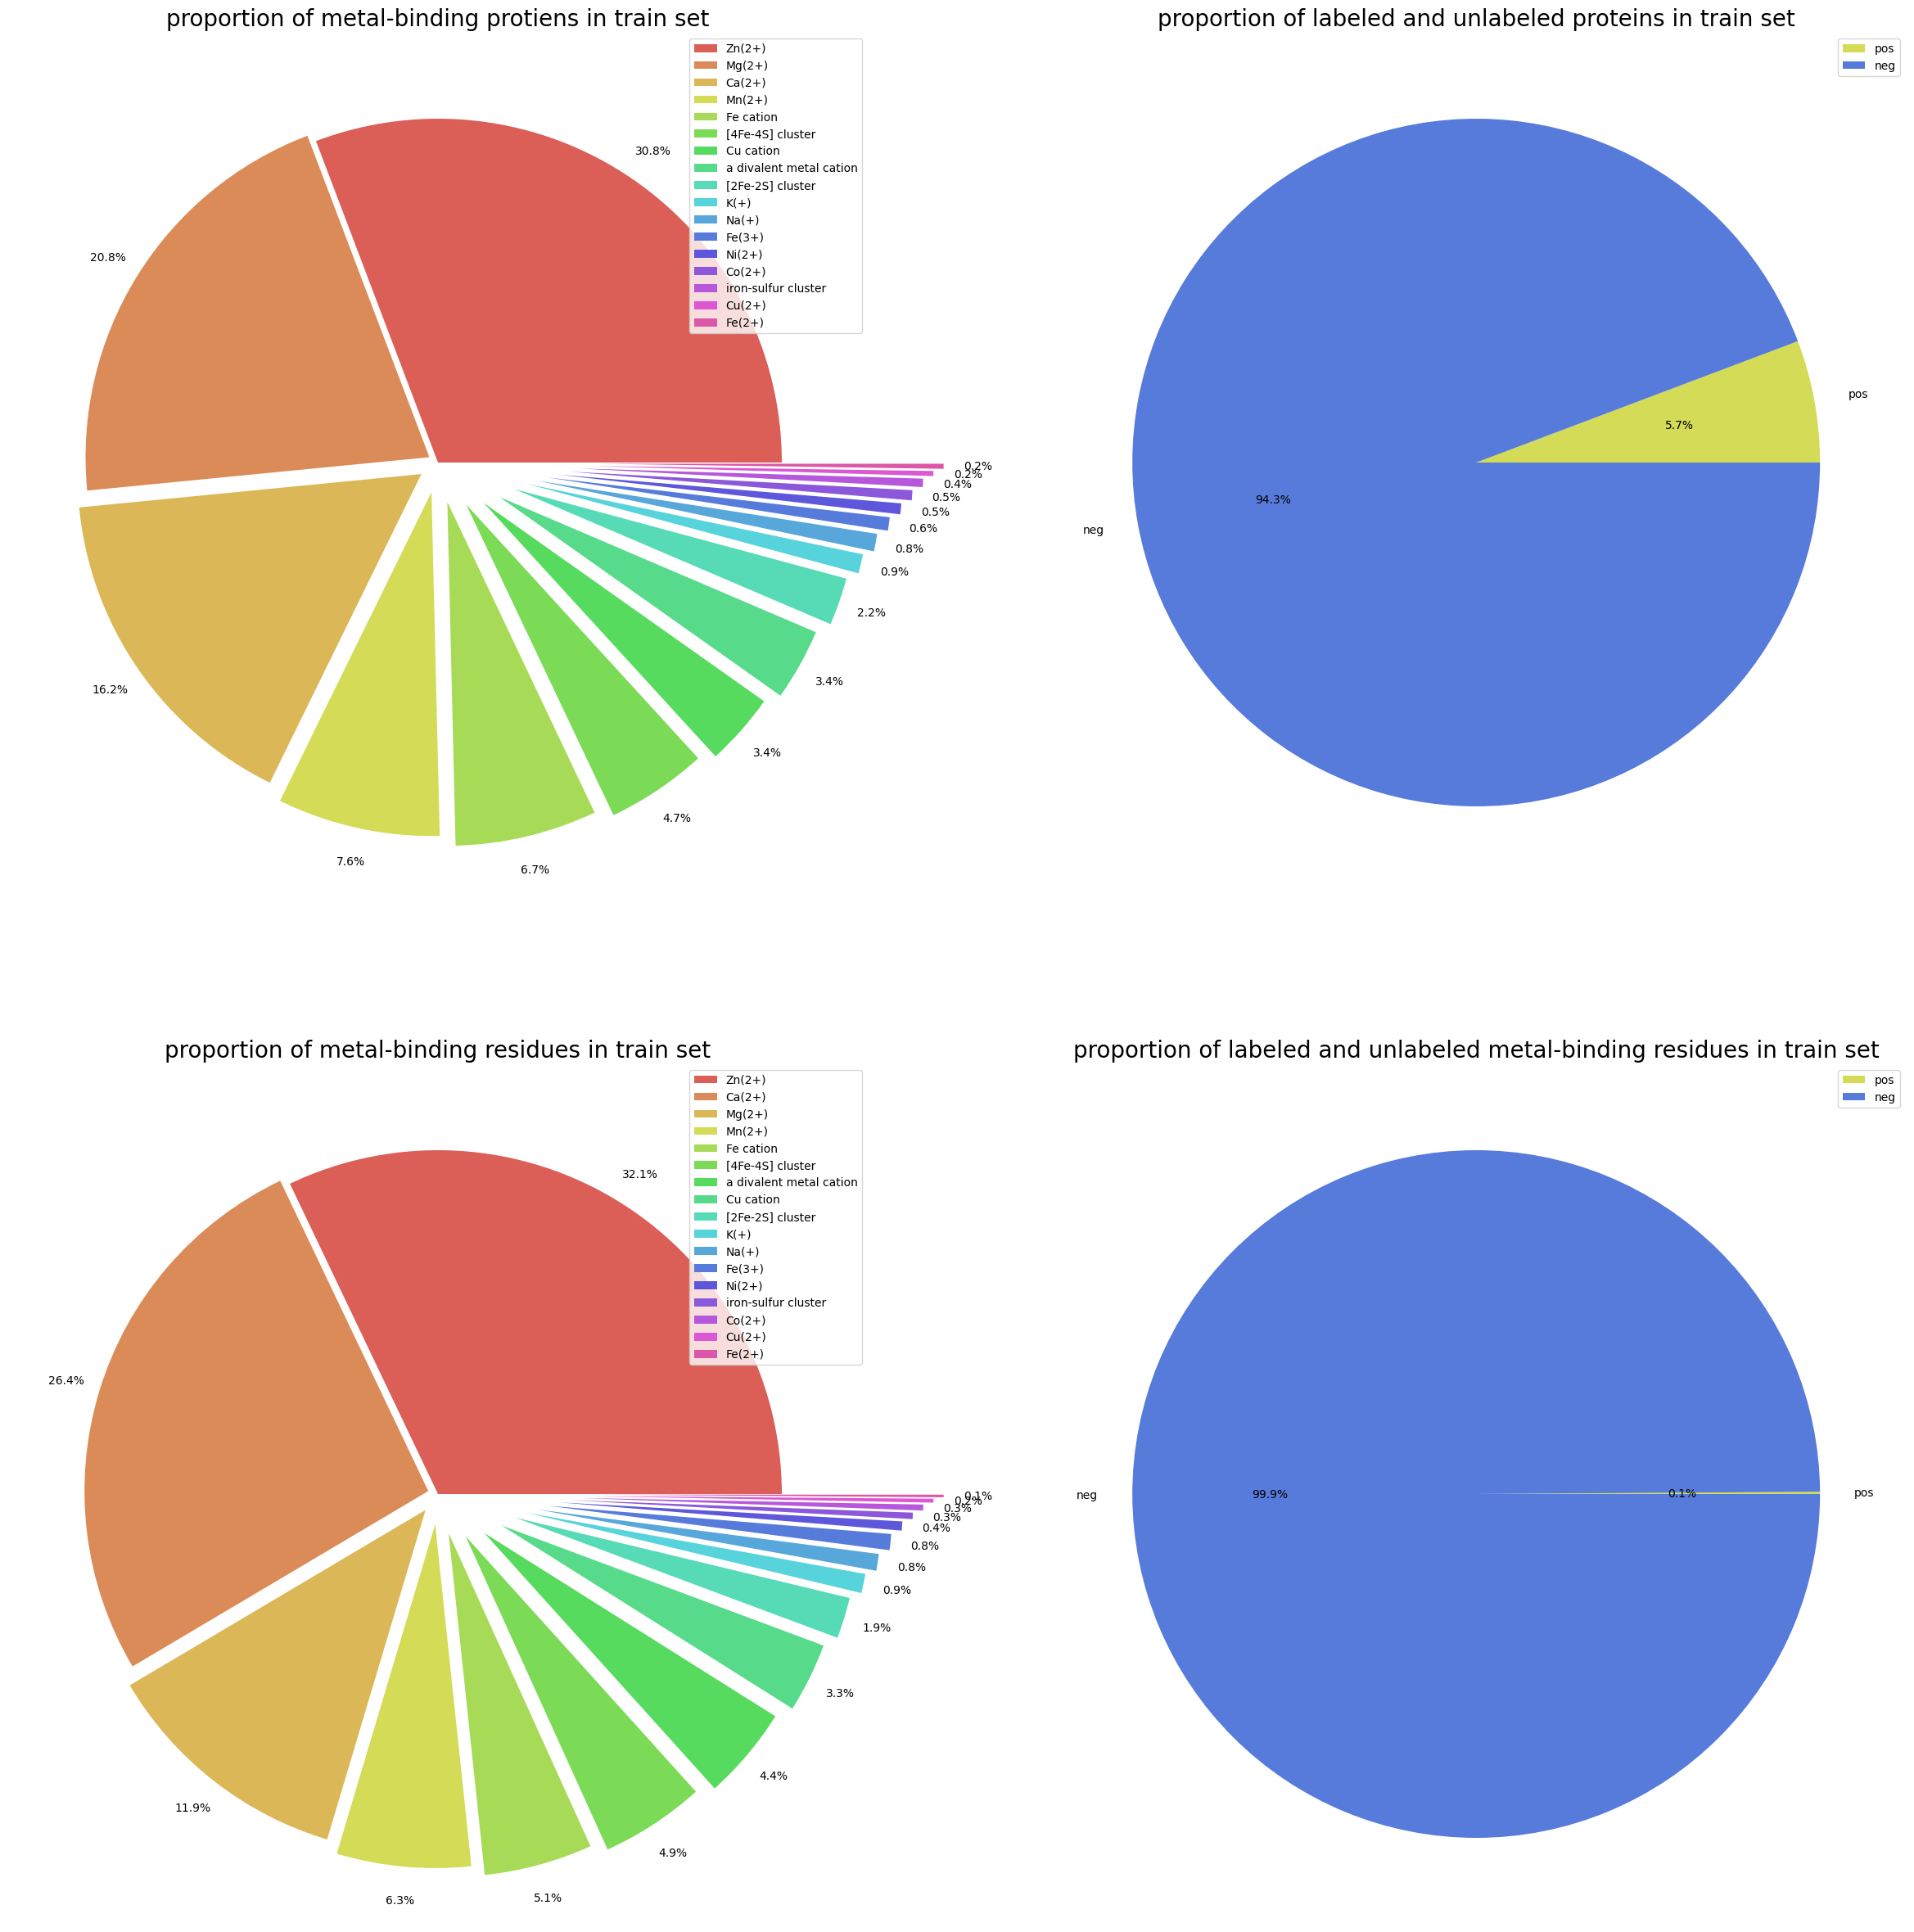

In [ ]:
plt.figure(figsize=(20,15))

fig, ax = plt.subplots(2,2, figsize=(30,30))
ax1 = ax[0,0]
ax2 =  ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]
metal_names = ['Zn(2+)', 'Mg(2+)', '[4Fe-4S] cluster', 'Ca(2+)', 'Mn(2+)', 'a divalent metal cation', 'Fe cation', '[2Fe-2S] cluster', 'Cu cation', 'K(+)', 'Ni(2+)', 'Na(+)', 'Fe(3+)', 'iron-sulfur cluster', 'Cu(2+)', 'Fe(2+)', 'Co(2+)']
temp_dc = pd.DataFrame({'metal_name':metal_names, 'count':pro_cnt[:17]})
temp_dc =  temp_dc.sort_values('count', ascending=False)
temp_dc1 = pd.DataFrame({'metal_name':metal_names, 'count':res_cnt[:17]})
temp_dc1 =  temp_dc1.sort_values('count', ascending=False)
explode = [i/34 for i in range(17)]
ax1.pie(temp_dc['count'], explode=explode, labels = temp_dc['metal_name'], colors = colors[:len(temp_dc['count'])], autopct='%1.1f%%', labeldistance=None, pctdistance=1.1)

ax1.set_title('proportion of metal-binding protiens in train set', fontsize=20)
ax1.legend()
ax3.pie(temp_dc1['count'], explode=explode, labels = temp_dc1['metal_name'], colors = colors[:len(temp_dc1['count'])], autopct='%1.1f%%', labeldistance=None, pctdistance=1.1)
ax3.set_title('proportion of metal-binding residues in train set', fontsize=20)
ax3.legend()

ax2.pie([2093, 34364], labels = ['pos', 'neg'], colors = [colors[3], colors[11]], autopct='%1.1f%%')
ax2.set_title('proportion of labeled and unlabeled proteins in train set', fontsize=20)
ax2.legend()

ax4.pie([np.sum(res_cnt), np.sum([len(i) for i in train_seq])-np.sum(res_cnt)], labels = ['pos', 'neg'], colors = [colors[3], colors[11]], autopct='%1.1f%%')
ax4.set_title('proportion of labeled and unlabeled metal-binding residues in train set', fontsize=20)
ax4.legend()



plt.show() 


## Test Set Summary

In [ ]:
pro_cnt, res_cnt = dataset_metal_binding_summary(test_acc, source = 'POS_TRAIN.tsv', coalesce=True)

total seq in the set: 3911, 2.0% of full dataset
#metal-binding protein: 224 
#non-binding protein: 3687 
pos/neg: 0.06075400054244643
CHEBI:29105  |Zn(2+)                        |#p:         91|#residue:    573
CHEBI:18420  |Mg(2+)                        |#p:         54|#residue:    208
CHEBI:49883  |[4Fe-4S] cluster              |#p:         11|#residue:     87
CHEBI:29108  |Ca(2+)                        |#p:         22|#residue:    471
CHEBI:29035  |Mn(2+)                        |#p:         23|#residue:    108
CHEBI:60240  |a divalent metal cation       |#p:          9|#residue:     77
CHEBI:24875  |Fe cation                     |#p:         12|#residue:     86
CHEBI:190135 |[2Fe-2S] cluster              |#p:          4|#residue:     38
CHEBI:23378  |Cu cation                     |#p:         10|#residue:     53
CHEBI:29103  |K(+)                          |#p:          3|#residue:     18
CHEBI:49786  |Ni(2+)                        |#p:          1|#residue:      4
CHEBI:29101  |Na(+

<Figure size 2000x1500 with 0 Axes>

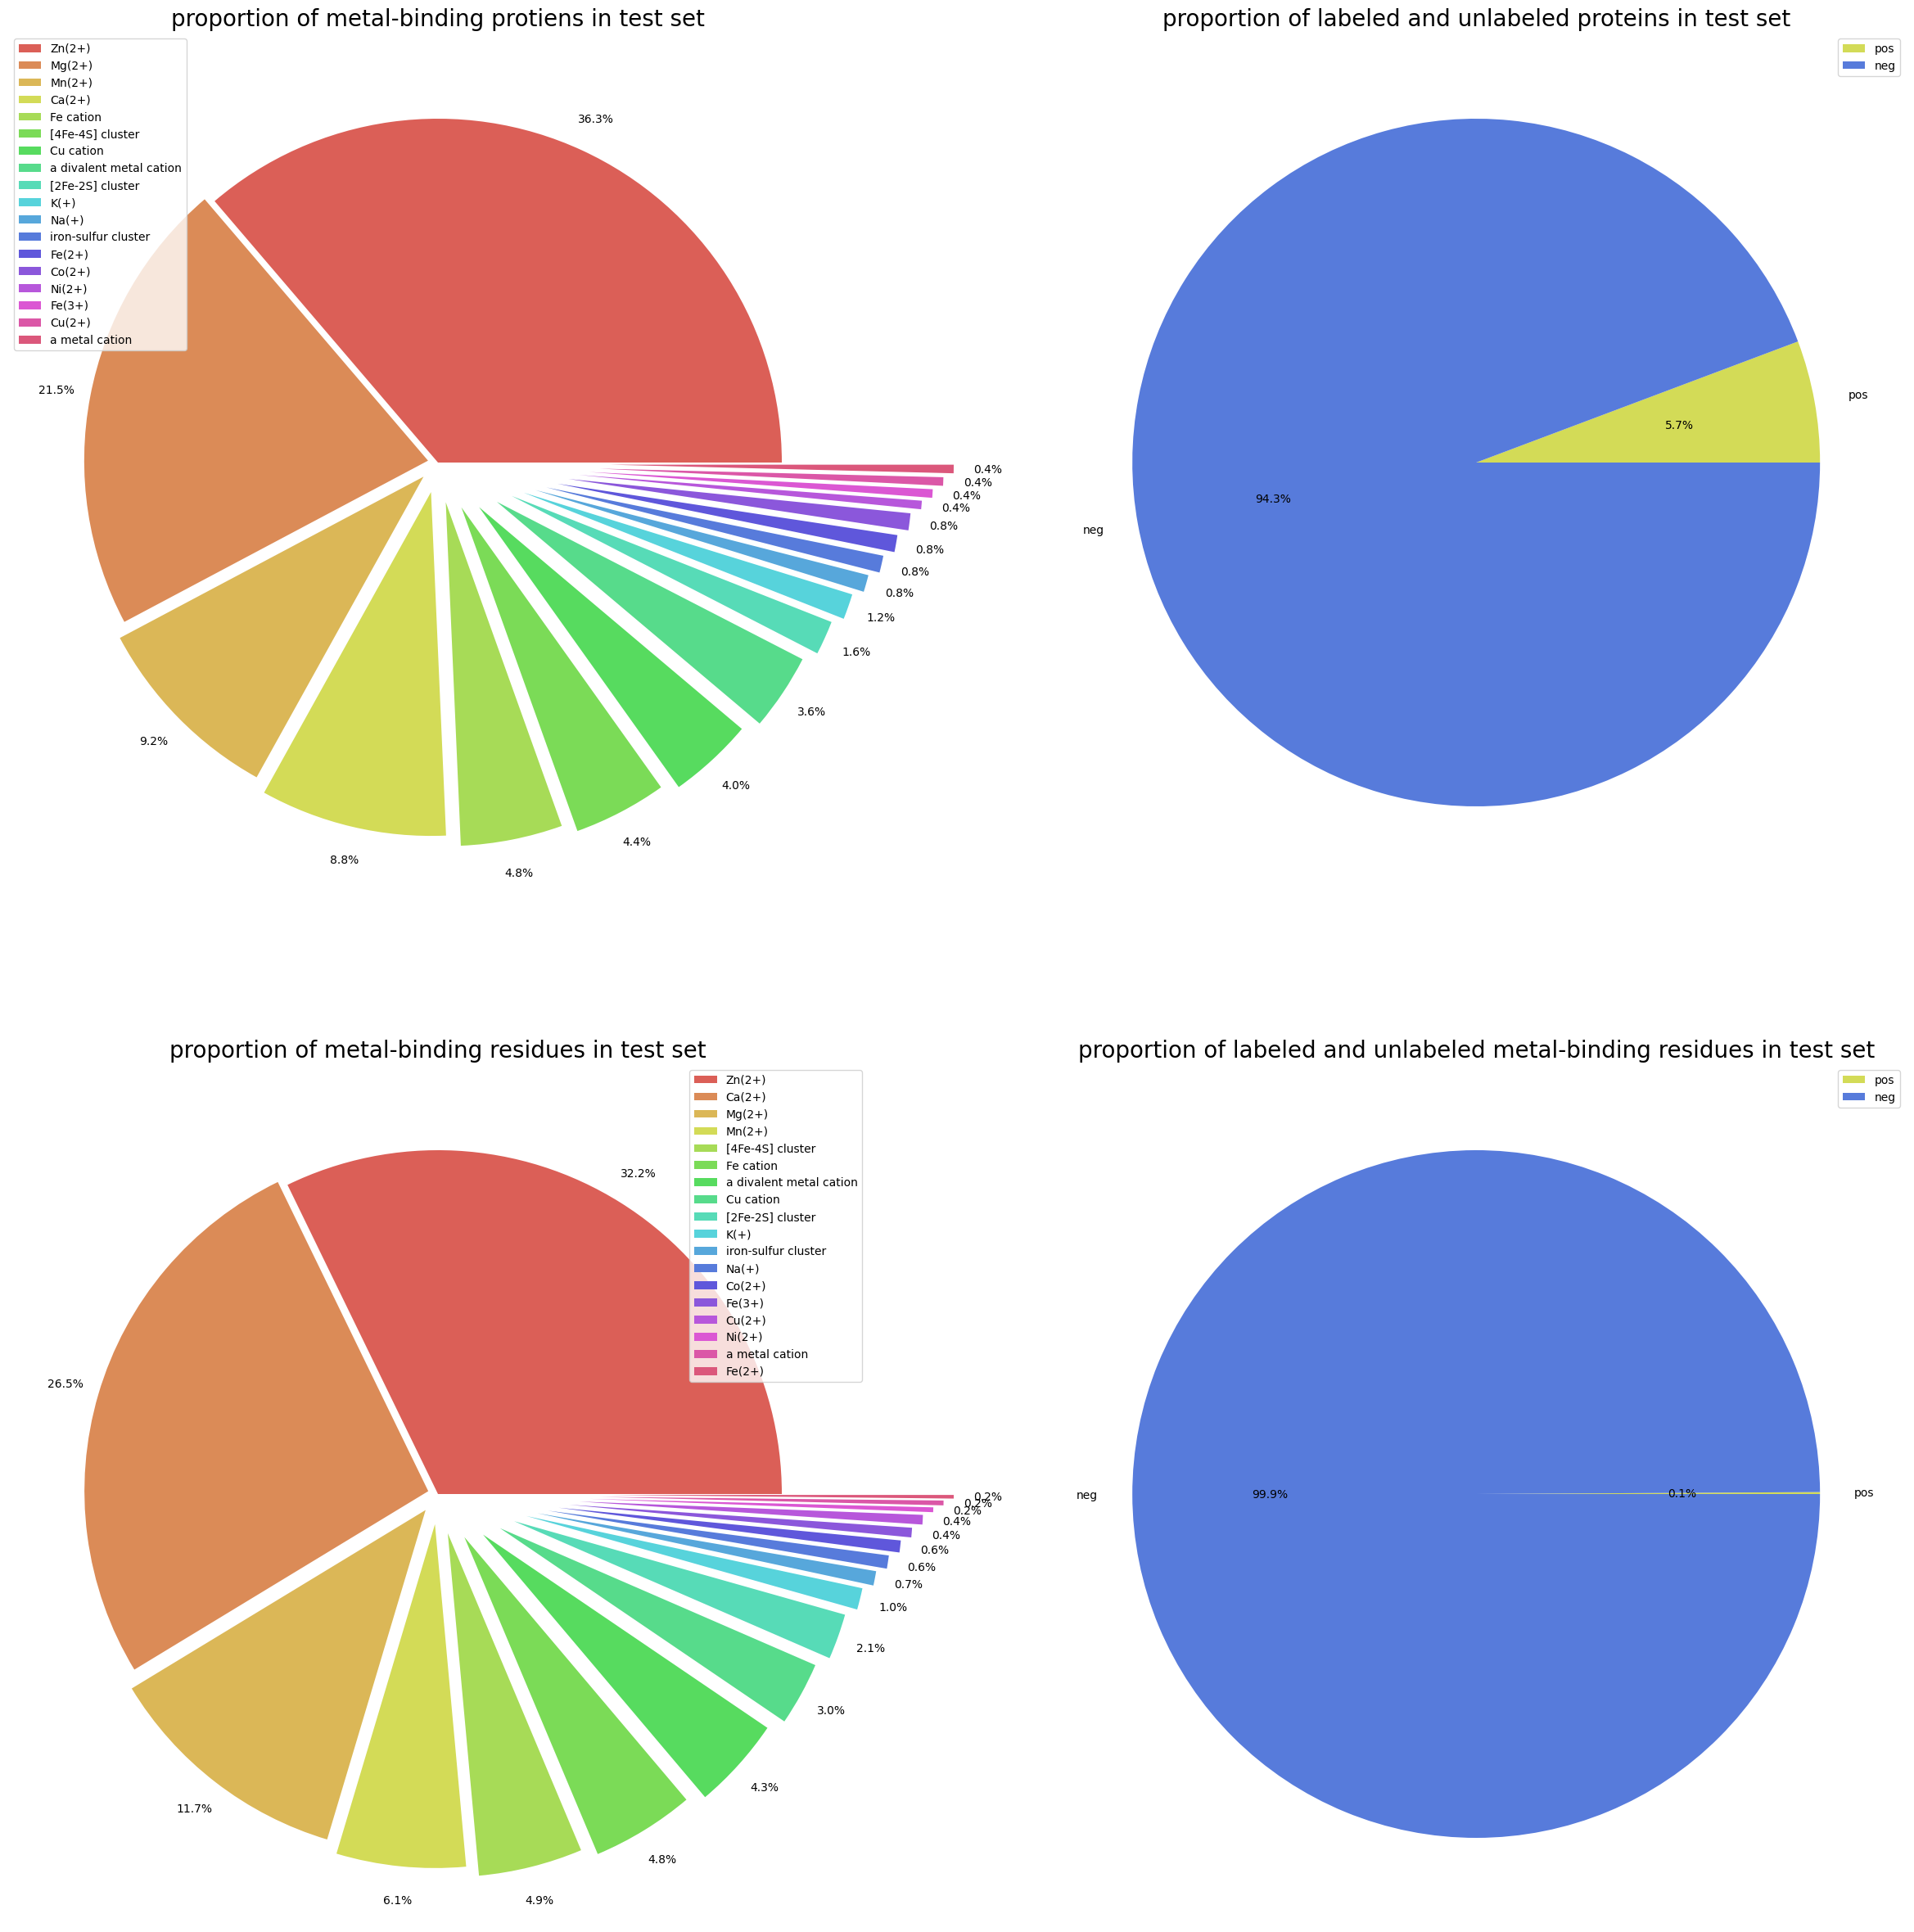

In [ ]:
plt.figure(figsize=(20,15))

fig, ax = plt.subplots(2,2, figsize=(30,30))
ax1 = ax[0,0]
ax2 =  ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]
metal_names = ['Zn(2+)', 'Mg(2+)', '[4Fe-4S] cluster', 'Ca(2+)', 'Mn(2+)', 'a divalent metal cation', 'Fe cation', '[2Fe-2S] cluster', 'Cu cation', 'K(+)', 'Ni(2+)', 'Na(+)', 'Fe(3+)', 'iron-sulfur cluster', 'Cu(2+)', 'Fe(2+)', 'Co(2+)', 'a metal cation']
temp_dc = pd.DataFrame({'metal_name':metal_names, 'count':pro_cnt[:18]})
temp_dc =  temp_dc.sort_values('count', ascending=False)
temp_dc1 = pd.DataFrame({'metal_name':metal_names, 'count':res_cnt[:18]})
temp_dc1 =  temp_dc1.sort_values('count', ascending=False)
explode = [i/34 for i in range(18)]
ax1.pie(temp_dc['count'], explode=explode, labels = temp_dc['metal_name'], colors = colors[:len(temp_dc['count'])], autopct='%1.1f%%', labeldistance=None, pctdistance=1.1)
ax1.set_title('proportion of metal-binding protiens in test set', fontsize=20)
ax1.legend()
ax3.pie(temp_dc1['count'], explode=explode, labels = temp_dc1['metal_name'], colors = colors[:len(temp_dc1['count'])], autopct='%1.1f%%', labeldistance=None, pctdistance=1.1)
ax3.set_title('proportion of metal-binding residues in test set', fontsize=20)
ax3.legend()

ax2.pie([224, 3687], labels = ['pos', 'neg'], colors = [colors[3], colors[11]], autopct='%1.1f%%')
ax2.set_title('proportion of labeled and unlabeled proteins in test set', fontsize=20)
ax2.legend()

ax4.pie([np.sum(res_cnt), np.sum([len(i) for i in test_seq])-np.sum(res_cnt)], labels = ['pos', 'neg'], colors = [colors[3], colors[11]], autopct='%1.1f%%')
ax4.set_title('proportion of labeled and unlabeled metal-binding residues in test set', fontsize=20)
ax4.legend()



plt.show() 

In [ ]:
metal_id_name_df = pd.read_csv('ChEBI-IDs_for_metal_binding.tsv', sep='\t')
metal_id_name_df

,ChEBI-ID,Name,ChEBI-ID Parents
0,CHEBI:48775,Cd(2+),"CHEBI:60240,CHEBI:25213"
1,CHEBI:29108,Ca(2+),"CHEBI:60240,CHEBI:25213"
2,CHEBI:48828,Co(2+),"CHEBI:60240,CHEBI:25213"
3,CHEBI:49415,Co(3+),CHEBI:25213
4,CHEBI:23378,Cu cation,CHEBI:25213
5,CHEBI:49552,Cu(+),"CHEBI:23378,CHEBI:25213"
6,CHEBI:29036,Cu(2+),"CHEBI:23378,CHEBI:60240,CHEBI:25213"
7,CHEBI:60240,a divalent metal cation,CHEBI:25213
8,CHEBI:190135,[2Fe-2S] cluster,CHEBI:30408
9,CHEBI:24875,Fe cation,CHEBI:25213
